### Predicting Gentrification at the Census Block Group Level

**Authors**: *Matthew Berry, Monica Flores, Zarni Htet and Yinglingyan Wang*

### Introduction

In this document, several logistic regression are fitted on the percentage change in white household ratios of a census block as an outcome variable.
By our literature review, any positive change in white household ratios of a neighborhood (in this notebook, we are looking at the census block group level) can be considered gentification. From our exploratory data analysis, we see a distribution of percent changes centered slightly on the negative side of zero. We have an initial consideration of 75th percentile as the cut-off point for distingushing those below it as non-gentrified and those above as gentrified.  

Some of the predictor variables for gentrification we have in consideration are as below:

* whether a Business Improve District (BIDs) is in the census block or not
* area of the Census Block Group the BIDs are under
* the duration of the BIDs year
* percentage of different racial composition of households in our base year of 2000
* borough_fixed effects
* neighborhood_fixed effects
* Number of workers of three different income levels in each census block group
* Number of workers of four different educational attainment in each census block group
* Distance of subway entraces of the center of each census block group
* Distance of small parks from the center of each census block group
* Distance of large parks from the center of each census block group

We are running several different models to determine which sets of predictors would most accurately predict gentrification. The models are as below:

* **Model I :** Gentrification = BID_Dummy + borough_fixed_effects + racial_composition_2000 
* **Model II:** Gentrification = borough_fixed_effects + racial_composition_2000 + workers of three different income levels + four different educational attainment + pct_ch_hinc00-10 + pct_ch_hedu00-10
* **Model III:** Gentrification = borough_fixed_effects + racial_composition_2000 + workers of three different income levels + four different educational attainment + distances of subways + distances of small parks + distances of large parks + total_number_of_new_housing_units
* **Model IV :** Gentrification =borough_fixed_effects + racial_composition_2000 + workers of three different income levels + four different educational attainment + distances of subways + distances of small parks + distances of large parks


The document is laid out in three main sections for each of the models:

* **Data Transformation** : This section primarily deals with joining the two datasets (specified later) that we are using to build this initial model as well as exploring certain key variables. Some variables are created and transformed to be fitted into the logistic model.

* **Data Modeling** : This section goes through cross validation scheme with different penalty terms for the logistic regression to come to the best AUC curve of the Precision-Recall trade-off.

* **Results** : This section goes through a comparison of different confusion matrixs, precision and recall to assess the quality of our different models.

After going through each model, we have a section on **All Results** discussion where we compare and contrast the models how they fare against each other with the **primary** metric being the AUC of the Precision-Recall trade-off chart.


#### Python Libraries

In [190]:
%pylab inline
from __future__ import division
import gzip
import csv
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import tree

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Model I

### Data Transformation

#### Loading the data

In this section, the two datasets are

* **block_dummies** : The data is from the Center for Urban Research, The Graduate Center, City University of New York (CUNY) http://www.urbanresearchmaps.org/plurality/blockmaps.htm. The data cleaning is done in **01_Block_Data_Clean.ipynb** for more details.

* **bids_ct** :The data is the BIDs data from NYC Open data with the BIDs being broken down into census block groups. The data processing is done in **04_BID_CT_matched_final.ipynb** for more details.


In [191]:
block_dummies = pd.read_csv("Data/block_dummies.csv", usecols=range(1,219), dtype= {'BLOCKID': str})

#### Initial Exploration of the datasets

In the next few blocks of code, we are going through checking the shape data as well as its summary statistics in order to verify that the data we are loading ins consistent with the data we have cleaned and processed in other parts of this code repository.

In [31]:
block_dummies.shape

(28376, 218)

In [32]:
block_dummies.head(3)

,BLOCKID,Pop10,Pop00,shWhite00,shLatino00,shBlack00,shAsian00,shOther00,pct_ch_white,pct_ch_hisp,...,NTACode_SI25,NTACode_SI28,NTACode_SI32,NTACode_SI35,NTACode_SI36,NTACode_SI37,NTACode_SI45,NTACode_SI48,NTACode_SI54,NTACode_SI99
0,360050300004003,249,272.0,58.088235,37.132353,1.102941,2.941176,0.735294,-17.525986,9.453992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,360050409001001,11,1119.0,1.340483,9.562109,86.058981,0.983021,2.055407,-1.340483,-9.562109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,360050409002000,3223,1886.0,26.988335,9.809120,59.172853,1.855779,2.173913,-12.498729,1.422652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
block_dummies.describe()

,Pop10,Pop00,shWhite00,shLatino00,shBlack00,shAsian00,shOther00,pct_ch_white,pct_ch_hisp,pct_ch_black,...,NTACode_SI25,NTACode_SI28,NTACode_SI32,NTACode_SI35,NTACode_SI36,NTACode_SI37,NTACode_SI45,NTACode_SI48,NTACode_SI54,NTACode_SI99
count,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,...,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000,28376.000000
mean,284.097759,277.798168,43.164015,20.564422,22.505705,10.001455,3.762477,-3.670099,2.133174,-0.755535,...,0.009621,0.006661,0.005075,0.004440,0.009727,0.005744,0.007964,0.006379,0.011524,0.000352
std,320.043241,315.775978,36.016818,22.771818,32.195377,14.992596,5.476979,12.613969,10.943116,9.026602,...,0.097614,0.081341,0.071057,0.066489,0.098144,0.075574,0.088889,0.079613,0.106731,0.018770
min,11.000000,10.010000,0.000000,0.000000,0.000000,0.000000,0.000000,-98.405823,-100.000000,-85.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,85.000000,4.444444,4.320988,0.000000,0.000000,0.000000,-9.166667,-2.407625,-2.325581,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,175.000000,169.000000,41.009215,11.111111,3.116905,3.529412,2.083333,-1.711457,1.537363,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,364.000000,353.000000,78.938616,29.166667,37.771818,13.461538,4.753400,1.360371,6.845016,1.501261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8634.000000,5460.649902,103.716511,102.639294,101.801092,100.000000,66.666667,98.420221,91.666667,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### BIDs distribution across Census Blockgroups

We examine the BIDs distribution across the census block groups. From the output of the mean, it can be seen that we have approximately only **2.26 percent** of the Census Blockgroups having BIDs. From both a machine learning paradigm of prediction as well as a traditional statistical paradigm, the low number of BIDs in the Census Blockgroups may mean that it is not necessarily predicitive nor statistically signifcant for the predictor to be of use in exploring gentrification. Nevertheless, we are going to run through some of the models mentioned above to see if our other variables contribute much to predicting gentrification. We want to highlight the BIDs as it is an initial interest of variable for the team.

In [34]:
#Looking in particular the BID dummies
block_dummies[['BID_dummy']].describe()

,BID_dummy
count,28376.00000
mean,0.02266
std,0.14882
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


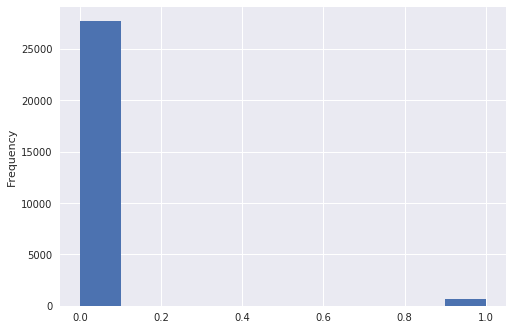

In [35]:
#on the BID series
fig, ax = plt.subplots()
ax = block_dummies['BID_dummy'].plot.hist()

#### Extracting columns for an initial dataset

In this section, several of our the columns from the main dataset are extracted to create a working dataset to run an initial logistic regression of **Model I. **

* **BLOCKID :**       The ID of the blocks
* **pct_ch_white :**         The percentage change of White people
* **bid_id :**         The ID of the BIDs
* **BID_dummy :**         If the block has BIDs or not
* **BoroName_Bronx :**         Borough name in Bronx
* **BoroName_Brooklyn:**         Borough name in Brooklyn
* **BoroName_Manhattan :**         Borough name in Manhattan
* **BoroName_Queens :**         Borough name in Queens
* **shWhite2000:**         The share of White people in 2000
* **shBlack2000:**         The share of Black people in 2000
* **shLatino2000:**         The share of Latino people in 2000
* **shAsian2000:**         The share of Asian people in 2000
* **shWhite2000:**         The share of White people in 2000



In [220]:
block_dummies_w= block_dummies[['BLOCKID','pct_ch_white','a_weight','bid_id','BID_dummy','BoroName_Bronx','BoroName_Brooklyn','BoroName_Manhattan','BoroName_Queens', 'shWhite00','shBlack00','shBlack00', 'shAsian00']]

##### Distribution of Percent Change in White Population

Below we explore the distribution of the percent change in White population by census block groups. The distribution is centered off to the negative side of 0 meaning there are more census block groups where White folks are leaving the census blocks

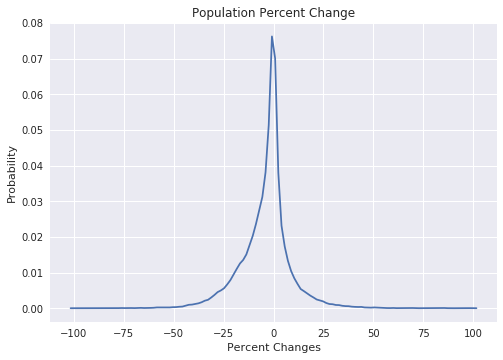

In [37]:
den, ax = plt.subplots()
ax = sns.distplot(block_dummies_w['pct_ch_white'], hist = False)
ax.set_title('Population Percent Change')
ax.set_xlabel('Percent Changes')
ax.set_ylabel('Probability')
plt.show()


##### Transforming percent change for logistic regression

As stated before, we are considering 75th percentile to be a cut-off point for the percentage change in White population as turning point for gentrification. 
At the 75th percentile, the percent change of White Population stands at **1.36** percent which is not much. 

In [211]:
#save the 75th percentile quantile for now
seventyfiveq = np.percentile(block_dummies_w['pct_ch_white'],75)

In [212]:
print(seventyfiveq)

1.36037091004


In [221]:
#changes dummy column
block_dummies_w["changesdummy"] = (block_dummies_w["pct_ch_white"] > seventyfiveq)

In [222]:
#converting them to 0 and 1
block_dummies_w.changesdummy = block_dummies_w.changesdummy.astype(int)

#### Class Balance Checking

In [223]:
#Reflecting the percentile breakdown we have established previously
block_dummies_w["changesdummy"].value_counts(normalize=True)

0    0.74759
1    0.25241
Name: changesdummy, dtype: float64

#### Training vs Testing data splitng

In [43]:
#Later on we will be using K-folds but this is a start
# Changed to 80% training
df_train, df_test = train_test_split(block_dummies_w, test_size=0.8)

#### Checking the distribution of both testing and training datasets

In [44]:
df_train.describe()

,pct_ch_white,a_weight,bid_id,BID_dummy,BoroName_Bronx,BoroName_Brooklyn,BoroName_Manhattan,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy
count,5675.000000,5675.000000,111.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000
mean,-3.680779,0.990140,990.873874,0.019559,0.125815,0.256388,0.087577,0.391189,43.571788,21.817016,21.817016,10.063884,0.252159
std,12.785284,0.056037,1314.455636,0.138493,0.331670,0.436677,0.282704,0.488060,36.072400,31.568981,31.568981,15.024307,0.434290
min,-76.923077,0.356635,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.429579,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,4.679306,0.000000,0.000000,0.000000,0.000000
50%,-1.913638,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,42.105263,3.076923,3.076923,3.592814,0.000000
75%,1.399335,1.000000,NaN,0.000000,0.000000,1.000000,0.000000,1.000000,79.516317,35.580689,35.580689,13.383055,1.000000
max,94.285714,1.000016,3957.000000,1.000000,1.000000,1.000000,1.000000,1.000000,103.626944,100.000000,100.000000,100.000000,1.000000


In [45]:
df_test.describe()

,pct_ch_white,a_weight,bid_id,BID_dummy,BoroName_Bronx,BoroName_Brooklyn,BoroName_Manhattan,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy
count,22701.000000,22701.000000,532.000000,22701.000000,22701.000000,22701.000000,22701.000000,22701.000000,22701.000000,22701.000000,22701.000000,22701.000000,22701.00000
mean,-3.667429,0.988576,924.109023,0.023435,0.125105,0.261222,0.086824,0.387824,43.062076,22.677870,22.677870,9.985848,0.24946
std,12.571061,0.060534,1162.730269,0.151284,0.330845,0.439310,0.281584,0.487265,36.002984,32.348468,32.348468,14.984949,0.43271
min,-98.405823,0.373523,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,-9.101058,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,4.382470,0.000000,0.000000,0.000000,0.00000
50%,-1.678322,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,40.845070,3.125000,3.125000,3.504043,0.00000
75%,1.348364,1.000000,NaN,0.000000,0.000000,1.000000,0.000000,1.000000,78.761062,38.365238,38.365238,13.479263,0.00000
max,98.420221,1.000016,3957.000000,1.000000,1.000000,1.000000,1.000000,1.000000,103.716511,101.801092,101.801092,100.000000,1.00000


#### Splitting into features and labels

In [46]:
#This is reflecting the Model I equation
sel_features = ['a_weight', 'BID_dummy', 'BoroName_Bronx', 'BoroName_Brooklyn', 'BoroName_Manhattan', 'BoroName_Queens','shWhite00', 'shBlack00', 'shAsian00']
sel_label = [ 'changesdummy']

In [47]:
#We are assigning predictors and the outcome in training and testing datasets
X_train = df_train[sel_features].values
y_train = df_train[sel_label].values
X_test = df_test[sel_features].values
y_test = df_test[sel_label].values

#### Fitting the model

In [48]:
#Inputting this into the traditional logistic regression model
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l1', C=1e5)
model.fit( X_train, y_train )
print(model)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


#### Model Understanding

In [49]:
print "The coefficients for each of the features are " 
zip(sel_features, model.coef_[0])

The coefficients for each of the features are 


[('a_weight', -1.4910853941249371),
 ('BID_dummy', 0.29555565828840918),
 ('BoroName_Bronx', -1.4592340222249283),
 ('BoroName_Brooklyn', 0.52788595883019063),
 ('BoroName_Manhattan', 0.71630305021587271),
 ('BoroName_Queens', -0.42829166243871014),
 ('shWhite00', -0.016084887666549651),
 ('shBlack00', -0.0083951227964144583),
 ('shAsian00', -0.0046060357652632881)]

In [50]:
print "The standardized coefficients of each of the features are"
std_coef = np.std(X_test,0)*model.coef_
zip(sel_features, std_coef[0])

The standardized coefficients of each of the features are


[('a_weight', -0.090258869052972618),
 ('BID_dummy', 0.044711903295631614),
 ('BoroName_Bronx', -0.48276934322587567),
 ('BoroName_Brooklyn', 0.23190064035823796),
 ('BoroName_Manhattan', 0.20169483410026984),
 ('BoroName_Queens', -0.20868689486832767),
 ('shWhite00', -0.57909119261221309),
 ('shBlack00', -0.27156338078624404),
 ('shAsian00', -0.14899491940385684)]

#### Model Evaluation

The logistic model outputs predictive probabilities as shown in plot below. We determine the cut-off point by estimating the point which we think have high enough probability to be considered gentrified. The initial estimates are picking the point by sizing the density of the graph above a particular cut-off point to reflect what we know of the composition of the outcome binary variable. A more scientific approach would be to use certain metrics such as **AUC-ROC** of sensitivty and 1-specificity or precision and recall to see how the model performs across all cut-off points. 

In [51]:
#  from our "predictors" using the model.
y_scores = model.predict_proba(X_test)[:,1]

#from our "predictors" using the model.
y_scores = model.predict_proba(X_test)[:,1]

In [52]:
y_scores

array([ 0.17911218,  0.51417124,  0.26290964, ...,  0.15689244,
        0.19444984,  0.45655227])

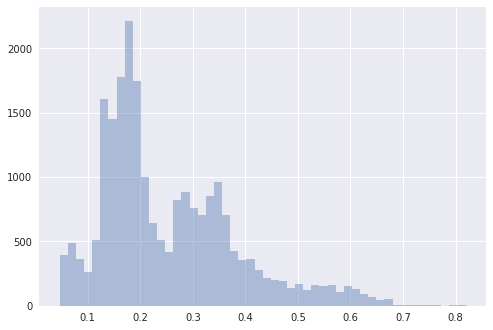

In [53]:
sns.distplot(y_scores, kde=False, rug=False)

In [54]:
df_test['y_score'] = y_scores

In [55]:
df_test[['y_score']].head()

,y_score
25923,0.179112
10946,0.514171
17427,0.262910
22759,0.173804
24044,0.178651


In [56]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.58) for score in y_scores] )
expected = y_test

#### Confusion Matrix

A confusion matrix is a quick way to access the quality of our model. It has the criteria as below:
* true positives : this is the case where we predict gentrification and there is actual gentrification
* true negatives : this is the case where we predict no gentrification and there is no gentrification
* false positivies : this is the case where we predict gentrification but there is actually no gentrification
* false negatives : this is the case where we predict no gentrification but there is actually gentrification

From our graph below which is colored to represent the volume of predictions, we are doing fairly well in predicting the true negatives but doing not so well, in predictive the true positives. In fact, as we will see later, our Model I is terrible at predicting true positives with very low precision scores.

In [57]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print conf_matrix

[[16839   199]
 [ 5222   441]]


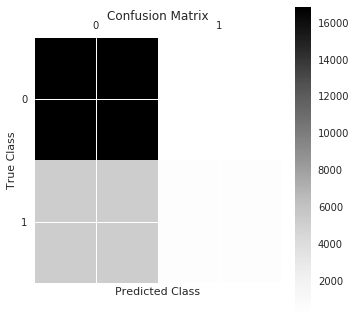

In [58]:
plt.matshow(conf_matrix)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### Null accuracy

The null accuracy is a measurement of how our model is performing if we have only predicted the majority class. In our case, the majority case is 0 which we have code to be **75 percent** by the quantile that we have picked. Therefore, our model must outperform a model accuracy of **75 percent**. Otherwise, our model is barely outperforming the baseline.

#### Model Evaluation Assessment

As can be seen below, our model is currently **barely** outperforming the null model with **75.5 percent** accuracy. The results are further reflected in our calculation of precision and recall further down. With recall/sensitivity score at **3.9 percent** we are doing fairly **terrible** for detecting **gentrification**. However, our **precision** rate stand at **74 percent**. At a first glance, it may look promising but as we plot the precision-recall trade-off graph later on the AUC stands at approximately 0.4 percent. Our first model is **bad** at predicting gentrification.

In [59]:
#generating accuracy
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.761199947139


In [60]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.6890625
Recall= 0.0778739184178


#### Plot Precision and Recall

In [61]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model I')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.437774


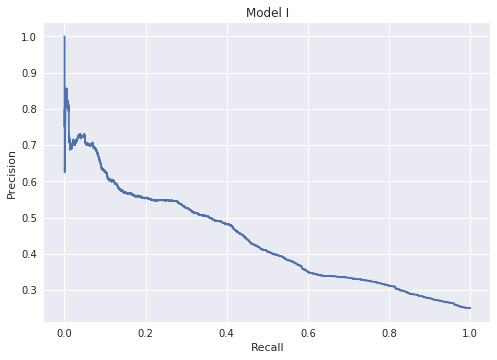

In [62]:
plot_precision_recall(expected, y_scores)

## Model II
Gentrification = borough_fixed_effects + racial_composition_2000 + workers of three different income levels + four different educational attainment + pct_ch_hinc00-10 + pct_ch_hedu00-10

In Model II, we will be adding two additional features in terms of workers' income levels and educational attainment by Census Block Group. The dataset is from OnTheMap (U.S.Census Bureau, Center for Economic Studies). https://onthemap.ces.census.gov/. The data cleaning process for this dataset is at **04_Workers_Residence_Data_Clean**


#### Variables of Interest in Workers Data


1. CE01 : Number of jobs with earnings 1250USD/month or less
2. CE02 : Number of jobs with earnings 1251USD/month to 3333USD/month
3. CE03 : Number of jobs with earnings greater than 3333USD/month
4. CD01 : Number of jobs for workers with Educational Attainment: Less than high school
5. CD02 : Number of jobs for workers with Educational Attainment: High School or Equivalent
6. CD03 : Number of jobs for workers with Educational Attainment: Some college or Associate Degree
7. CD04 : Number of jobs for workers with Educational Attainment: Bachelor's degree or Advanced Degree

In [217]:
workers_02_10 = pd.read_csv("Data/workers_02_10_Clean.csv", usecols=range(1,18), dtype= {'BLOCKID': str})

workers_02_10.shape

(29192, 17)

In [94]:
workers_02_10.head()

,BLOCKID,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,Inc03_2010,Ed01_2010,Ed02_2010,Ed03_2010,Ed04_2010,pct_ch_hInc,pct_ch_hEduc
0,360050001001000,32,30,15,0,0,0,0,35,48,32,13,21,27,19,1.125828,190.0
1,360050001001013,31,20,6,0,0,0,0,14,22,23,9,10,15,8,2.786885,80.0
2,360050002001000,15,48,15,0,0,0,0,24,55,63,24,36,26,26,3.178808,260.0
3,360050002001001,19,31,19,0,0,0,0,11,28,32,9,11,21,12,0.680628,120.0
4,360050002001002,26,43,16,0,0,0,0,14,50,40,20,22,20,19,1.490683,190.0


In [226]:
#The working race composition data from before
block_dummies_w.head()

,BLOCKID,pct_ch_white,a_weight,bid_id,BID_dummy,BoroName_Bronx,BoroName_Brooklyn,BoroName_Manhattan,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy
0,360050300004003,-17.525986,1.0,NaN,0,1.0,0.0,0.0,0.0,58.088235,1.102941,1.102941,2.941176,0
1,360050409001001,-1.340483,1.0,NaN,0,1.0,0.0,0.0,0.0,1.340483,86.058981,86.058981,0.983021,0
2,360050409002000,-12.498729,1.0,NaN,0,1.0,0.0,0.0,0.0,26.988335,59.172853,59.172853,1.855779,0
3,360050419001004,-5.535527,1.0,NaN,0,1.0,0.0,0.0,0.0,19.313305,6.437768,6.437768,11.587983,0
4,360050449011006,-3.571429,1.0,NaN,0,1.0,0.0,0.0,0.0,71.428571,0.000000,0.000000,0.000000,0


In [227]:
#Joining the two datasets to create another dataset for model running
workers_02_10_block_working = workers_02_10.merge(block_dummies_w, left_on = 'BLOCKID', right_on = 'BLOCKID', how = "inner")
workers_02_10_block_working.shape

(29196, 30)

### Training and Testing data splits

In [97]:
#Later on we will be using K-folds but this is a start
# Changed to 80% training
df_train, df_test = train_test_split(workers_02_10_block_working, test_size=0.8)

In [98]:
df_train.describe()

,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,Inc03_2010,...,BID_dummy,BoroName_Bronx,BoroName_Brooklyn,BoroName_Manhattan,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy
count,5675.000000,5675.000000,5675.000000,5675.0,5675.0,5675.0,5675.0,5675.000000,5675.000000,5675.000000,...,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000,5675.000000
mean,28.649868,39.755595,30.830308,0.0,0.0,0.0,0.0,18.925286,33.692863,49.948722,...,0.023965,0.130749,0.258678,0.090749,0.383612,43.453449,22.668783,22.668783,9.817980,0.249692
std,33.604260,45.345449,49.862072,0.0,0.0,0.0,0.0,21.878580,38.564431,68.170808,...,0.152953,0.337155,0.437947,0.287277,0.486308,36.148083,32.245172,32.245172,14.823257,0.432873
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,12.000000,9.000000,0.0,0.0,0.0,0.0,5.000000,10.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.414718,0.000000,0.000000,0.000000,0.000000
50%,17.000000,25.000000,17.000000,0.0,0.0,0.0,0.0,12.000000,21.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,42.307692,3.414634,3.414634,3.468208,0.000000
75%,36.000000,52.000000,32.000000,0.0,0.0,0.0,0.0,25.000000,45.000000,57.500000,...,0.000000,0.000000,1.000000,0.000000,1.000000,79.091845,38.229715,38.229715,13.290919,0.000000
max,410.000000,735.000000,852.000000,0.0,0.0,0.0,0.0,287.000000,569.000000,1069.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,102.951272,100.000000,100.000000,100.000000,1.000000


In [99]:
df_test.describe()

,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,Inc03_2010,...,BID_dummy,BoroName_Bronx,BoroName_Brooklyn,BoroName_Manhattan,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy
count,22700.000000,22700.000000,22700.000000,22700.0,22700.0,22700.0,22700.0,22700.000000,22700.000000,22700.000000,...,22700.000000,22700.000000,22700.000000,22700.000000,22700.000000,22700.000000,22700.000000,22700.000000,22700.000000,22700.000000
mean,28.143040,39.247225,30.461278,0.0,0.0,0.0,0.0,18.681938,33.344097,49.339692,...,0.022599,0.123833,0.260749,0.086035,0.389692,43.083400,22.472812,22.472812,10.046295,0.250220
std,33.474762,45.181133,50.229925,0.0,0.0,0.0,0.0,21.472417,37.755936,67.848270,...,0.148625,0.329398,0.439053,0.280422,0.487691,35.976186,32.182392,32.182392,15.034142,0.433149
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,12.000000,9.000000,0.0,0.0,0.0,0.0,5.000000,10.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.458528,0.000000,0.000000,0.000000,0.000000
50%,17.000000,25.000000,17.000000,0.0,0.0,0.0,0.0,12.000000,21.000000,29.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,40.740741,3.053435,3.053435,3.539823,0.000000
75%,35.000000,50.000000,31.000000,0.0,0.0,0.0,0.0,24.000000,44.000000,56.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,78.846154,37.591489,37.591489,13.517957,1.000000
max,609.000000,868.000000,1044.000000,0.0,0.0,0.0,0.0,310.000000,629.000000,2218.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,103.716511,101.801092,101.801092,100.000000,1.000000


In [100]:
#This is reflecting the Model I equation
sel_features = ['a_weight', 'BID_dummy', 'BoroName_Bronx', 'BoroName_Brooklyn', 'BoroName_Manhattan', 'BoroName_Queens','shWhite00', 'shBlack00', 'shAsian00', 'Inc01_2002', 'Inc02_2002', 'Inc03_2002','Ed01_2002', 'Ed02_2002','Ed03_2002','Ed04_2002','pct_ch_hInc', 'pct_ch_hEduc']
sel_label = [ 'changesdummy']

In [101]:
#We are assigning predictors and the outcome in training and testing datasets
X_train = df_train[sel_features].values
y_train = df_train[sel_label].values
X_test = df_test[sel_features].values
y_test = df_test[sel_label].values

In [102]:
#Inputting this into the traditional logistic regression model
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l1', C=1e5)
model.fit( X_train, y_train )
print(model)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [103]:
y_scores = model.predict_proba(X_test)[:,1]

In [104]:
y_scores

array([ 0.44848868,  0.17119847,  0.21916426, ...,  0.1949655 ,
        0.27630015,  0.42220394])

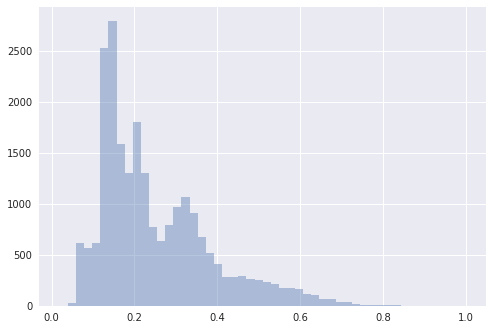

In [105]:
sns.distplot(y_scores, kde=False, rug=False)

In [106]:
df_test['y_score'] = y_scores

In [107]:
df_test[['y_score']].head()

,y_score
8015,0.448489
15303,0.171198
15854,0.219164
21550,0.128355
18381,0.161615


In [108]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.58) for score in y_scores] )
expected = y_test

In [109]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print conf_matrix

[[16766   254]
 [ 5208   472]]


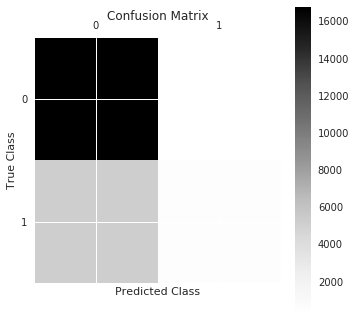

In [110]:
plt.matshow(conf_matrix)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [111]:
#generating accuracy
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.759383259912


In [112]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.650137741047
Recall= 0.0830985915493


In [113]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model II')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.439852


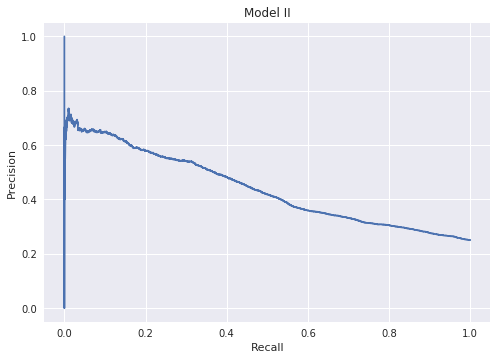

In [114]:
plot_precision_recall(expected, y_scores)

## Model III
Gentrification = borough_fixed_effects + racial_composition_2000 + workers of three different income levels + four different educational attainment + + pct_ch_hinc + pct_ch_hedu + distances of subways + distances of small parks + distances of large parks + New Units permits after 2010

In Model III, we will be adding in three additonal features of subway, small park and large park distances from the center of each census block group. We are aware that these features represent physical infrastructure that does not change much over time. We are hoping to capture that an existing presence could affect residents' decision to move-in or move-out of census block groups and neighborhoods. A more pertinent dataset would be where new investments in subways and parks happen over time which we hope to obtain next. The data is obtained from NYC Open data (https://nycopendata.socrata.com/Transportation/Subway-Entrances/drex-xx56) and the cleaning is done in GIS.

In [228]:
#Import data on distance to the nearest subway entrance, 
#nearest big park (larger than 3 acres) and nearest small park (less than 3 acres but more than 0.1 acres to exlude microparks)
subwaysparks = pd.read_csv("Data/dist_subway_parks_final.csv",dtype= {'BLOCKID': str} )
subwaysparks.shape

(39009, 4)

In [195]:
subwaysparks.head()

,BLOCKID,dist_sub_m,dist_sPark,dist_lPark
0,360050516005011,4741.830078,5270.879883,911.674011
1,360050300004003,103.175003,1220.680054,78.367500
2,360050409001001,323.865997,308.806000,111.860001
3,360050409002000,240.684998,179.690002,209.363007
4,360050411001000,96.200104,17.205500,37.777100


In [229]:
#Import data on DOB occupancy permits for number of new units permited per block after 2010
newunits = pd.read_csv("Data/DOB_new_units_Clean.csv", usecols=range(1,3), dtype= {'BLOCKID': str, 'PR_DWELLING_UNIT': int} )
newunits.shape

(29353, 2)

In [197]:
newunits.head()

,BLOCKID,PR_DWELLING_UNIT
0,360050002001000,0
1,360050002001004,48
2,360050002002002,2
3,360050002002003,0
4,360050004002003,4


In [198]:
# Remove NaNs in BLOCKID if there are
subwayParksClean = [x for x in subwaysparks['BLOCKID'] if x != 'nan']
subwaysparks.shape

(39009, 4)

In [206]:
workers_02_10_block_working.shape

(28375, 30)

In [230]:
#Joining subway data to workers data from before
workers_subway = workers_02_10_block_working.merge(subwaysparks, left_on = 'BLOCKID', right_on = 'BLOCKID', how = "inner")
workers_subway.head()

,BLOCKID,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,...,BoroName_Manhattan,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy,dist_sub_m,dist_sPark,dist_lPark
0,360050001001000,32,30,15,0,0,0,0,35,48,...,0.0,0.0,8.521221,60.605009,60.605009,0.260854,0,2990.620117,2112.219971,1333.260010
1,360050001001013,31,20,6,0,0,0,0,14,22,...,0.0,0.0,8.487242,60.517723,60.517723,0.184505,0,2802.429932,1970.089966,1057.729981
2,360050002001000,15,48,15,0,0,0,0,24,55,...,0.0,0.0,9.885932,26.235741,26.235741,3.041825,0,2024.540039,443.230011,297.609009
3,360050002001001,19,31,19,0,0,0,0,11,28,...,0.0,0.0,7.853403,27.225131,27.225131,0.000000,0,2014.689941,477.950989,278.540008
4,360050002001002,26,43,16,0,0,0,0,14,50,...,0.0,0.0,3.859649,24.561404,24.561404,0.000000,0,2007.910034,522.379028,240.309998


In [232]:
# Join DOB data on new units approved
workers_subway_units = workers_subway.merge(newunits, left_on = 'BLOCKID', right_on = 'BLOCKID', how = "inner")
workers_subway_units.head()

,BLOCKID,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,...,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy,dist_sub_m,dist_sPark,dist_lPark,PR_DWELLING_UNIT
0,360050001001000,32,30,15,0,0,0,0,35,48,...,0.0,8.521221,60.605009,60.605009,0.260854,0,2990.620117,2112.219971,1333.260010,0
1,360050001001013,31,20,6,0,0,0,0,14,22,...,0.0,8.487242,60.517723,60.517723,0.184505,0,2802.429932,1970.089966,1057.729981,0
2,360050002001000,15,48,15,0,0,0,0,24,55,...,0.0,9.885932,26.235741,26.235741,3.041825,0,2024.540039,443.230011,297.609009,0
3,360050002001001,19,31,19,0,0,0,0,11,28,...,0.0,7.853403,27.225131,27.225131,0.000000,0,2014.689941,477.950989,278.540008,0
4,360050002001002,26,43,16,0,0,0,0,14,50,...,0.0,3.859649,24.561404,24.561404,0.000000,0,2007.910034,522.379028,240.309998,0


In [233]:
#Save in the Data folder for further exploration and visualization
workers_subway_units.to_csv("Data/Blocks_full_dataset.csv", encoding='utf8')

### Training and Testing data splits


In [164]:
#Later on we will be using K-folds but this is a start
# Changed to 80% training
df_train, df_test = train_test_split(workers_subway_units, test_size=0.8)

In [165]:
df_train.head()

,BLOCKID,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,...,BoroName_Queens,shWhite00,shBlack00,shBlack00,shAsian00,changesdummy,dist_sub_m,dist_sPark,dist_lPark,PR_DWELLING_UNIT
2668,360050373002000,28,36,12,0,0,0,0,22,40,...,0.0,1.186944,47.774481,47.774481,0.000000,0,1160.819946,168.147995,86.203102,0
18701,360810594001003,10,23,22,0,0,0,0,10,21,...,1.0,2.142857,95.000000,95.000000,0.000000,0,4636.779785,762.026001,1459.050049,0
27414,360850207001023,7,13,5,0,0,0,0,2,9,...,0.0,11.250000,52.500000,52.500000,1.250000,0,5164.709961,370.348999,151.509995,0
9045,360470746001004,29,52,30,0,0,0,0,20,37,...,0.0,62.323944,20.070423,20.070423,3.873239,1,1539.589966,104.720001,930.645996,0
17269,360810466002001,58,91,102,0,0,0,0,47,83,...,1.0,21.580547,27.355623,27.355623,31.914894,0,61.622799,124.445999,725.507019,6


In [166]:
df_train.columns

Index([u'BLOCKID', u'Inc01_2002', u'Inc02_2002', u'Inc03_2002', u'Ed01_2002',
       u'Ed02_2002', u'Ed03_2002', u'Ed04_2002', u'Inc01_2010', u'Inc02_2010',
       u'Inc03_2010', u'Ed01_2010', u'Ed02_2010', u'Ed03_2010', u'Ed04_2010',
       u'pct_ch_hInc', u'pct_ch_hEduc', u'pct_ch_white', u'a_weight',
       u'bid_id', u'BID_dummy', u'BoroName_Bronx', u'BoroName_Brooklyn',
       u'BoroName_Manhattan', u'BoroName_Queens', u'shWhite00', u'shBlack00',
       u'shBlack00', u'shAsian00', u'changesdummy', u'dist_sub_m',
       u'dist_sPark', u'dist_lPark', u'PR_DWELLING_UNIT'],
      dtype='object')

In [171]:
#This is reflecting the Model I equation
sel_features = ['a_weight', 'BID_dummy', 'BoroName_Bronx', 'BoroName_Brooklyn', 'BoroName_Manhattan', 'BoroName_Queens','shWhite00', 'shBlack00', 'shAsian00', 'Inc01_2002', 'Inc02_2002', 'Inc03_2002','Ed01_2002', 'Ed02_2002','Ed03_2002','Ed04_2002','pct_ch_hInc', 'pct_ch_hEduc','dist_sub_m','dist_sPark','dist_lPark','PR_DWELLING_UNIT' ]
sel_label = [ 'changesdummy']

In [173]:
#We are assigning predictors and the outcome in training and testing datasets
X_train = df_train[sel_features].values
y_train = df_train[sel_label].values
X_test = df_test[sel_features].values
y_test = df_test[sel_label].values

In [174]:
#Inputting this into the traditional logistic regression model
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l1', C=1e5)
model.fit( X_train, y_train )
print(model)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [175]:
y_scores = model.predict_proba(X_test)[:,1]

In [176]:
y_scores

array([ 0.29904747,  0.44879932,  0.18995231, ...,  0.14993074,
        0.1152726 ,  0.07575466])

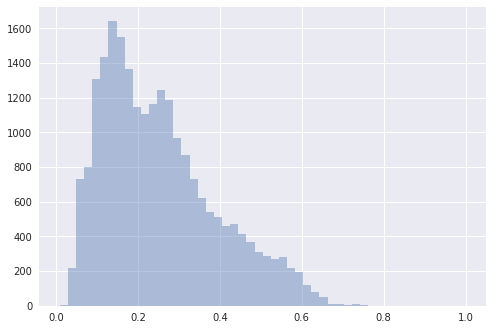

In [177]:
sns.distplot(y_scores, kde=False, rug=False)

In [178]:
df_test['y_score'] = y_scores

In [179]:
df_test[['y_score']].head()

,y_score
14701,0.299047
5802,0.448799
20356,0.189952
3841,0.366919
3617,0.524816


In [180]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.58) for score in y_scores] )
expected = y_test

In [181]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print conf_matrix

[[16857   172]
 [ 5319   359]]


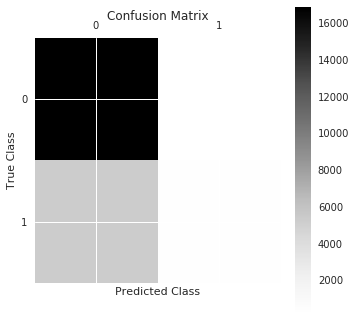

In [182]:
plt.matshow(conf_matrix)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [183]:
#generating accuracy
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.758180296825


In [184]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.676082862524
Recall= 0.0632264882001


In [187]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Model III')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.444286


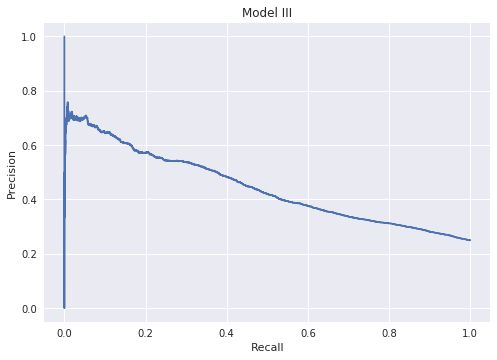

In [188]:
plot_precision_recall(expected, y_scores)